# Link de tutorial:
https://youtu.be/qQELiV1_GHA


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importar imágenes

In [2]:
from get_images import get_images

In [76]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)
y_test = y_test_num.copy().reshape(10000, 1)

/tmp/ipykernel_8305/3774853967.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
/tmp/ipykernel_8305/3774853967.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)


# Normalizaf imágenes

In [77]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [78]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [66]:
x_test.shape

(10000, 784)

In [67]:
y_train.shape

(50000, 1)

# Mostrar imágenes

In [42]:
def plot_number(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 7


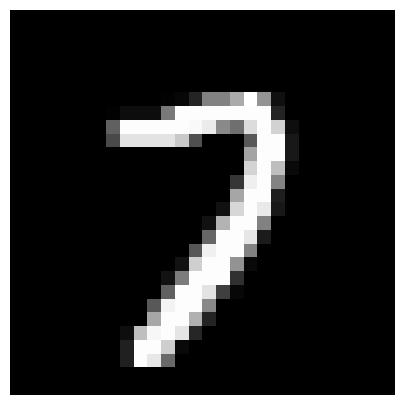

In [43]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx][0]}')
plot_number(x_test_num[rnd_idx])

# Crear minibatches

In [79]:
def create_minibatches(x, y, mb_size, shuffle=True):
    '''
    x  # muestras, 784
    y # muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Convertir Numpy array a PyTorch tensor

In [68]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

In [56]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Compute accuracy


In [650]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            scores = model(xi) # (mb_size, 10)
            pred = scores.argmax(dim=1) # Return de max value and index, this vector return of shape (mb_size).
            num_correct += (pred==yi.squeeze()).sum() # yi have dimention of (batch_size, 1) so squeeze change dimention to  (mb_size).
            num_total += pred.size(0)
        
        return float(num_correct)/num_total
            
            
            
    




In [651]:
x_train_tensor.shape

torch.Size([50000, 784])

# Loop de entrenamiento

In [732]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            scores = model(xi)
            
       
            # Funcion cost
            cost = F.cross_entropy(
                input=scores,
                target=yi.squeeze(),
                
            )
            optimizer.zero_grad()
            
            cost.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch+1}, costo: {cost.item()}, accuracy {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
        
            
    



# Modelo usando Sequential

In [733]:
# Instanciar model
hidden1 = 200
hidden = 200
out_features = 10
lr = 1e-2
epochs = 20
mb_size = 32
model1 = nn.Sequential(
    nn.Linear(in_features=784, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=out_features)
    
)

In [734]:

optimizer = torch.optim.SGD(model1.parameters(), lr=lr)

In [735]:

train(model1, optimizer, mb_size, epochs)

Epoch: 1, costo: 0.23754945397377014, accuracy 0.9236
Epoch: 2, costo: 0.10200522094964981, accuracy 0.9416
Epoch: 3, costo: 0.3701179325580597, accuracy 0.9527
Epoch: 4, costo: 0.1986532360315323, accuracy 0.9582
Epoch: 5, costo: 0.2478952258825302, accuracy 0.962
Epoch: 6, costo: 0.07357707619667053, accuracy 0.9674
Epoch: 7, costo: 0.06208086386322975, accuracy 0.9692
Epoch: 8, costo: 0.09509190171957016, accuracy 0.9703
Epoch: 9, costo: 0.1874171942472458, accuracy 0.9712
Epoch: 10, costo: 0.1297401487827301, accuracy 0.9726
Epoch: 11, costo: 0.6440955996513367, accuracy 0.9726
Epoch: 12, costo: 0.004894021432846785, accuracy 0.974
Epoch: 13, costo: 0.027778729796409607, accuracy 0.975
Epoch: 14, costo: 0.033005859702825546, accuracy 0.9743
Epoch: 15, costo: 0.07156600058078766, accuracy 0.9749
Epoch: 16, costo: 0.010151092894375324, accuracy 0.9757
Epoch: 17, costo: 0.13079728186130524, accuracy 0.9752
Epoch: 18, costo: 0.026506779715418816, accuracy 0.9759
Epoch: 19, costo: 0.005

In [736]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.9769

In [739]:

predict

tensor(2, device='cuda:0')

La imagen muestreada representa un: 6
Precition: 6


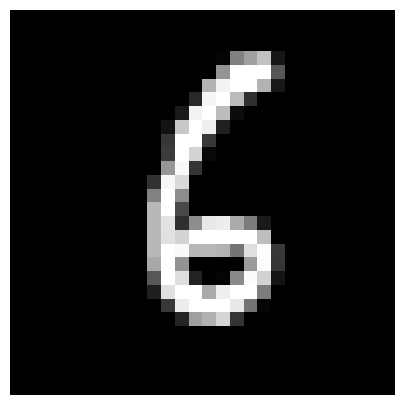

In [760]:
with torch.no_grad():
    rnd_idx = np.random.randint(len(y_train))
    print(f'La imagen muestreada representa un: {y_train[rnd_idx][0]}')
    predict = model1(input=x_train_tensor[rnd_idx,:].float().to(device=device)).argmax()
    print(f'Precition: {predict}')
    plot_number(x_train_num[rnd_idx])
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')